# Week 4 - Bayesian Optimization

Generate optimized recommendations for Week 4 using utility modules.

## Setup

In [1]:
import numpy as np
import warnings
import sys
import importlib
sys.path.append('..')  # Add parent directory to path

# Import utility modules (reload to pick up any code changes)
import utils.bayesian_optimization
importlib.reload(utils.bayesian_optimization)
from utils.bayesian_optimization import propose_next_point, fit_gp, get_strategy

from utils.data_utils import (
    load_week_data,
    save_week_data,
    combine_with_week_results, 
    print_data_summary
)

## 1. Load Week 3 Data

Load the combined data from previous weeks

In [2]:
# Load Week 3 clean data
inputs, outputs = load_week_data("../week 3/week3_clean_data.npz")
print_data_summary(inputs, outputs, "Week 3 Data")


Data loaded from ../week 3/week3_clean_data.npz

Week 3 Data:
  Function 1: 12 points, 2D, best = 0.097870
  Function 2: 12 points, 2D, best = 0.613847
  Function 3: 17 points, 3D, best = -0.034835
  Function 4: 32 points, 4D, best = 0.352325
  Function 5: 22 points, 4D, best = 1688.068784
  Function 6: 22 points, 5D, best = -0.520988
  Function 7: 32 points, 6D, best = 1.784483
  Function 8: 42 points, 8D, best = 9.649282


## 2. Add Week 3 Results

In [3]:
# Week 3 submitted points
week3_inputs = {
    1: np.array([0.408138, 0.404748]),
    2: np.array([0.813470, 0.137077]),
    3: np.array([0.992210, 0.000000, 0.000000]),
    4: np.array([0.394731, 0.386792, 0.430560, 0.420751]),
    5: np.array([0.937863, 1.000000, 1.000000, 1.000000]),
    6: np.array([0.902076, 0.195368, 0.734603, 0.561943, 0.155898]),
    7: np.array([0.000000, 0.238111, 0.820828, 0.126481, 0.352484, 0.885496]),
    8: np.array([0.144443, 0.040302, 0.100000, 0.127071, 1.000000, 0.021611, 0.100000, 0.984114])
}

# Week 3 outputs (received from black box)
week3_outputs = {
    1: 0.32547065237773726,
    2: 0.0480422918344799,
    3: -0.1749553993662295,
    4: 0.42256108847277263,
    5: 7599.502461741096,
    6: -1.0560487918151704,
    7: 1.372035137814457,
    8: 9.6971798574364
}

# Combine with Week 3 results
inputs, outputs = combine_with_week_results(inputs, outputs, week3_inputs, week3_outputs)
print_data_summary(inputs, outputs, "After Week 3 Results")


After Week 3 Results:
  Function 1: 13 points, 2D, best = 0.325471
  Function 2: 13 points, 2D, best = 0.613847
  Function 3: 18 points, 3D, best = -0.034835
  Function 4: 33 points, 4D, best = 0.422561
  Function 5: 23 points, 4D, best = 7599.502462
  Function 6: 23 points, 5D, best = -0.520988
  Function 7: 33 points, 6D, best = 1.784483
  Function 8: 43 points, 8D, best = 9.697180


In [4]:
# Save combined data for Week 5
save_week_data(inputs, outputs, "week4_clean_data.npz")


Data saved to week4_clean_data.npz


## 3. Week 3 Results Analysis

Evaluate which strategies worked and which failed to inform Week 4 approach.

In [5]:
# Week 3 results analysis
print("=" * 70)
print("WEEK 3 RESULTS ANALYSIS")
print("=" * 70)

# Track best values before and after Week 3
# Best values after Week 2 (before Week 3 query)
best_before_w3 = {}
for fid in range(1, 9):
    # All outputs except the last one (which is Week 3)
    best_before_w3[fid] = np.max(outputs[fid][:-1])

print(f"\n{'F':>2} {'Dims':>4} {'Best Before W3':>14} {'W3 Query':>14} {'New Best':>14} {'Status'}")
print("-" * 70)

improved = 0
for fid in range(1, 9):
    dim = inputs[fid].shape[1]
    prev_best = best_before_w3[fid]
    w3_val = week3_outputs[fid]
    new_best = np.max(outputs[fid])
    
    if w3_val >= prev_best:
        status = "NEW BEST"
        improved += 1
    else:
        status = f"miss (best still {prev_best:.4f})"
    
    print(f"{fid:>2} {dim:>3}D {prev_best:>14.4f} {w3_val:>14.4f} {new_best:>14.4f}   {status}")

print(f"\nWeek 3 hit rate: {improved}/8 functions improved")
print("=" * 70)

WEEK 3 RESULTS ANALYSIS

 F Dims Best Before W3       W3 Query       New Best Status
----------------------------------------------------------------------
 1   2D         0.0979         0.3255         0.3255   NEW BEST
 2   2D         0.6138         0.0480         0.6138   miss (best still 0.6138)
 3   3D        -0.0348        -0.1750        -0.0348   miss (best still -0.0348)
 4   4D         0.3523         0.4226         0.4226   NEW BEST
 5   4D      1688.0688      7599.5025      7599.5025   NEW BEST
 6   5D        -0.5210        -1.0560        -0.5210   miss (best still -0.5210)
 7   6D         1.7845         1.3720         1.7845   miss (best still 1.7845)
 8   8D         9.6493         9.6972         9.6972   NEW BEST

Week 3 hit rate: 4/8 functions improved


## 4. Sensitivity Analysis

Updated sensitivity analysis with Week 3 data to inform Week 4 strategies.


Function 1 (2D) - Sensitivity Analysis
Baseline (best point): [0.408138 0.404748]
Baseline output: 0.325471

Dimension 1: Max gradient = 0.0000 (flat - less important)
Dimension 2: Max gradient = 0.0000 (flat - less important)


/Users/mariana.lozynska/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


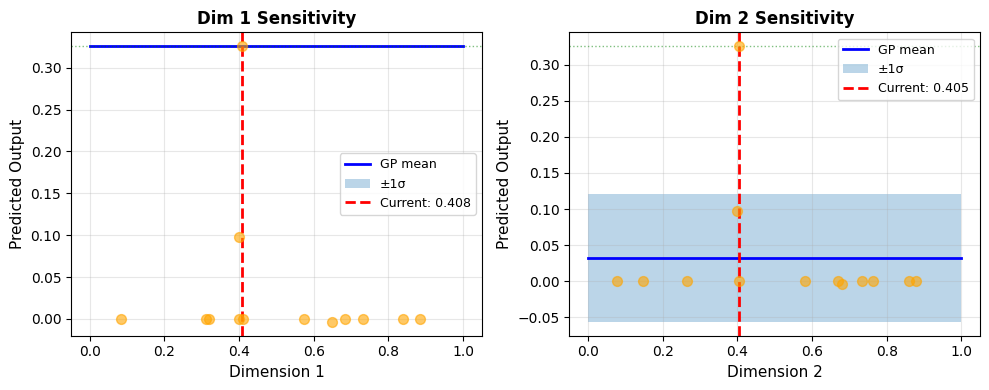



Function 2 (2D) - Sensitivity Analysis
Baseline (best point): [0.700073 0.125362]
Baseline output: 0.613847

Dimension 1: Max gradient = 0.2627 (flat - less important)
Dimension 2: Max gradient = 0.0000 (flat - less important)


/Users/mariana.lozynska/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


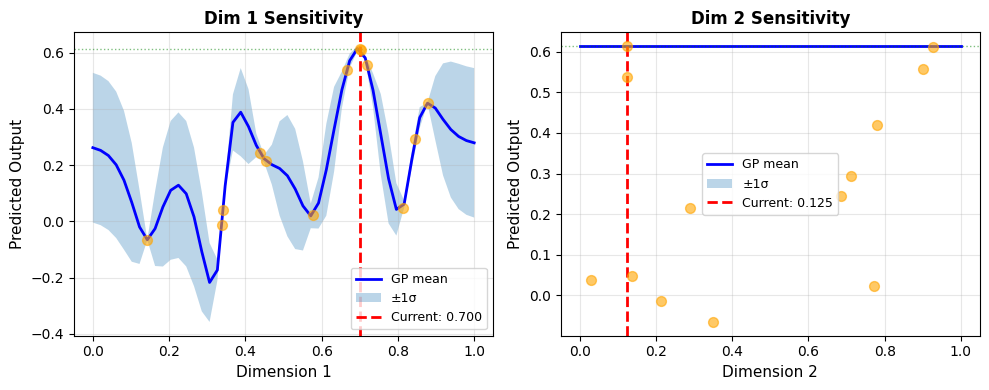


Function 3 (3D) - Sensitivity Analysis
Baseline (best point): [0.49258141 0.61159319 0.34017639]
Baseline output: -0.034835

Dimension 1: Max gradient = 0.0000 (flat - less important)
Dimension 2: Max gradient = 0.0014 (flat - less important)
Dimension 3: Max gradient = 0.0870 (flat - less important)


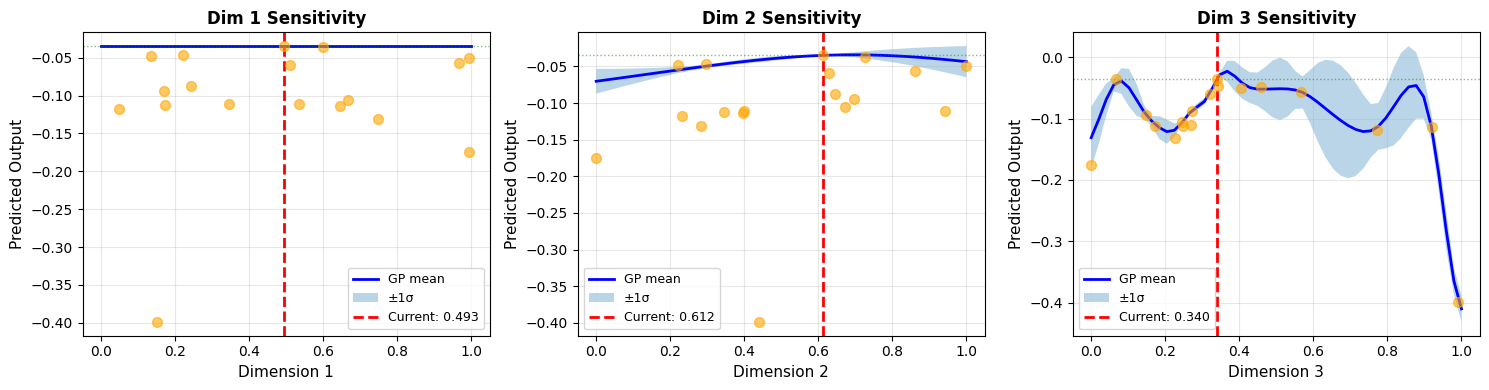


Function 4 (4D) - Sensitivity Analysis
Baseline (best point): [0.394731 0.386792 0.43056  0.420751]
Baseline output: 0.422561

Dimension 1: Max gradient = 0.8305 (flat - less important)
Dimension 2: Max gradient = 0.8737 (flat - less important)
Dimension 3: Max gradient = 1.0290 (steep - important)
Dimension 4: Max gradient = 0.9085 (flat - less important)


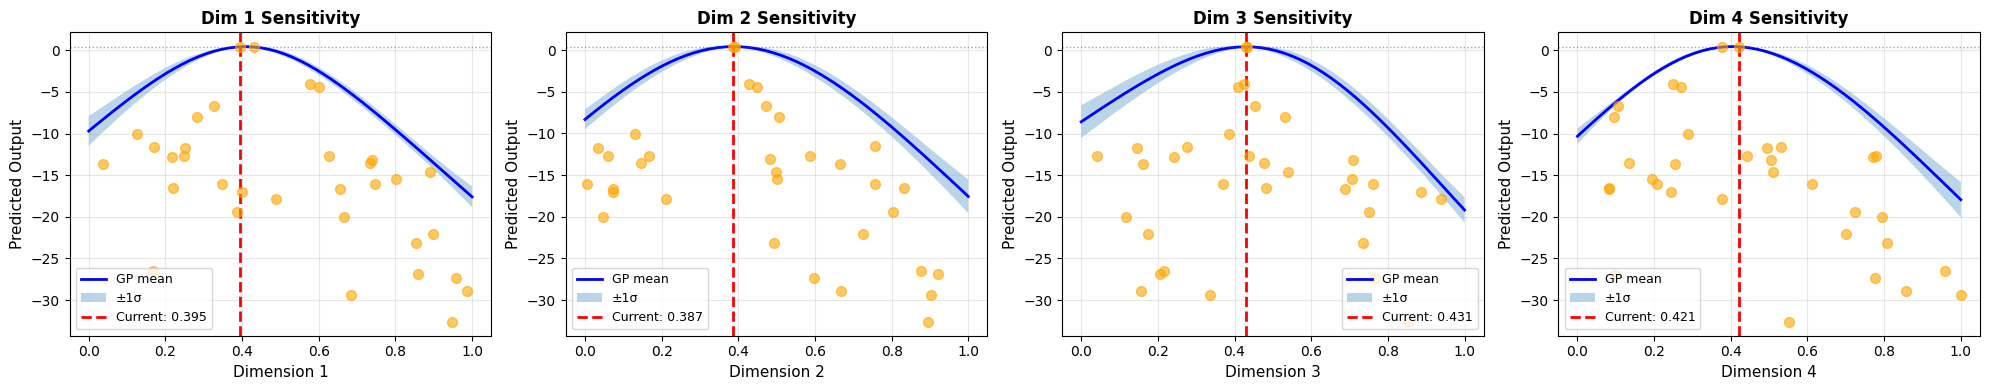


Function 5 (4D) - Sensitivity Analysis
Baseline (best point): [0.937863 1.       1.       1.      ]
Baseline output: 7599.502462

Dimension 1: Max gradient = 173.0892 (steep - important)
Dimension 2: Max gradient = 98.4687 (steep - important)
Dimension 3: Max gradient = 221.6909 (steep - important)
Dimension 4: Max gradient = 98.6007 (steep - important)


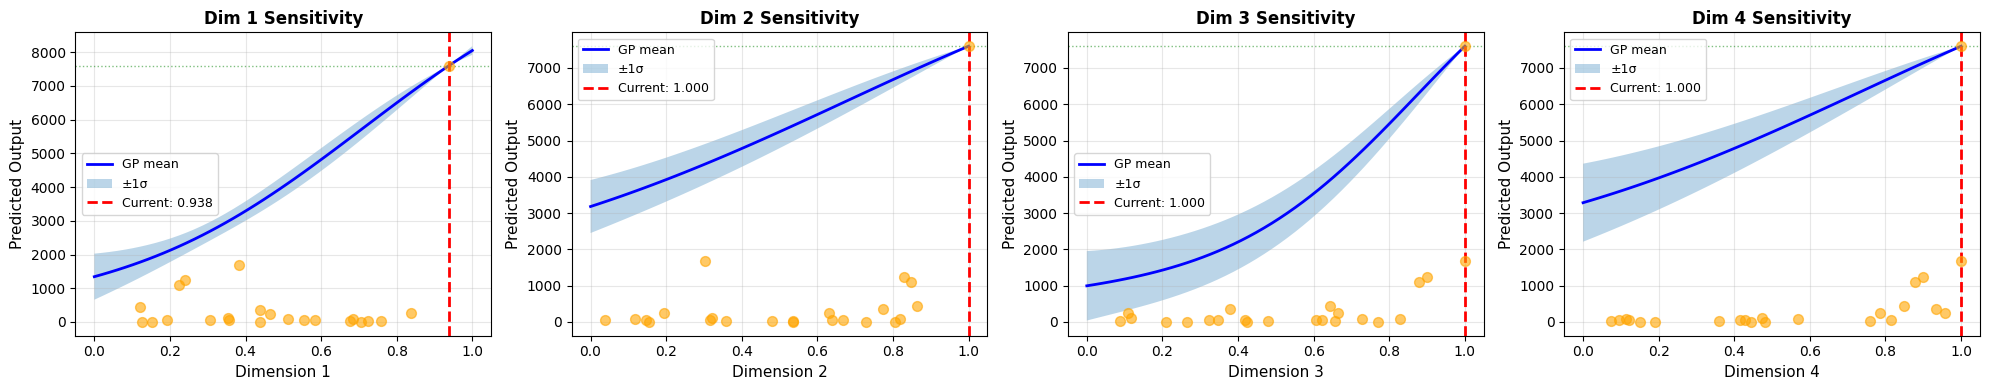


Function 6 (5D) - Sensitivity Analysis
Baseline (best point): [0.755469 0.27058  0.644099 0.672228 0.162862]
Baseline output: -0.520988

Dimension 1: Max gradient = 0.0000 (flat - less important)
Dimension 2: Max gradient = 0.1101 (flat - less important)
Dimension 3: Max gradient = 0.2287 (flat - less important)
Dimension 4: Max gradient = 0.0000 (flat - less important)
Dimension 5: Max gradient = 0.0000 (flat - less important)


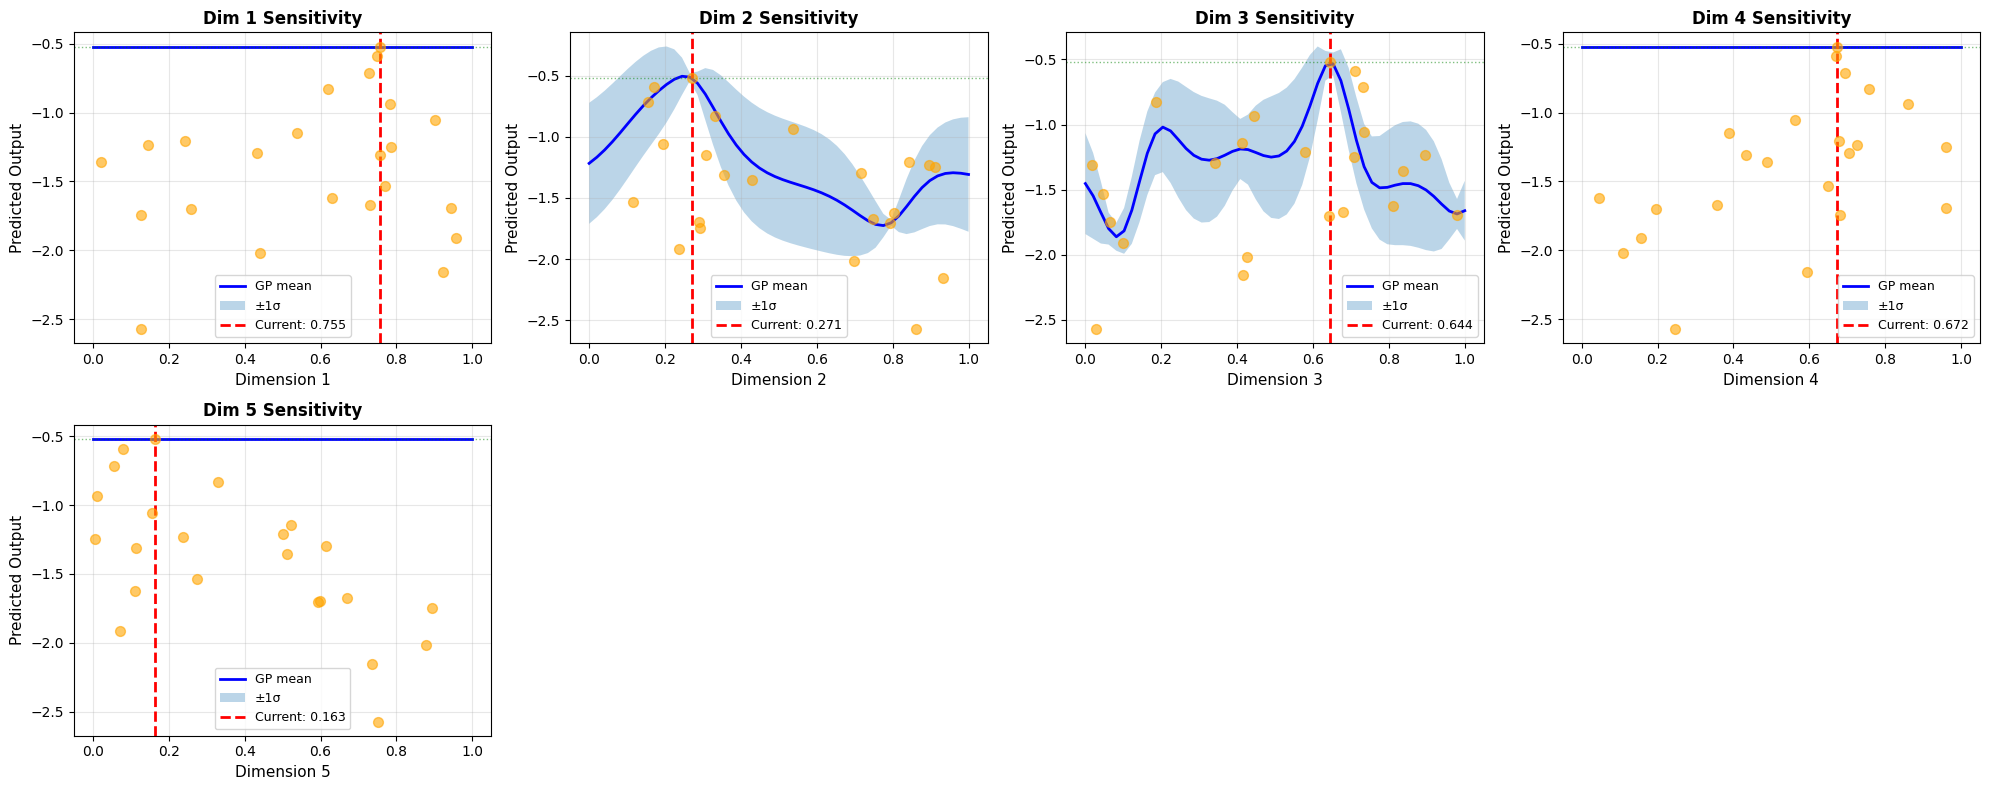


Function 7 (6D) - Sensitivity Analysis
Baseline (best point): [0.       0.342263 0.707844 0.246481 0.405689 0.778028]
Baseline output: 1.784483

Dimension 1: Max gradient = 0.0219 (flat - less important)
Dimension 2: Max gradient = 0.0000 (flat - less important)
Dimension 3: Max gradient = 0.0223 (flat - less important)
Dimension 4: Max gradient = 0.0695 (flat - less important)
Dimension 5: Max gradient = 0.1059 (flat - less important)
Dimension 6: Max gradient = 0.0689 (flat - less important)


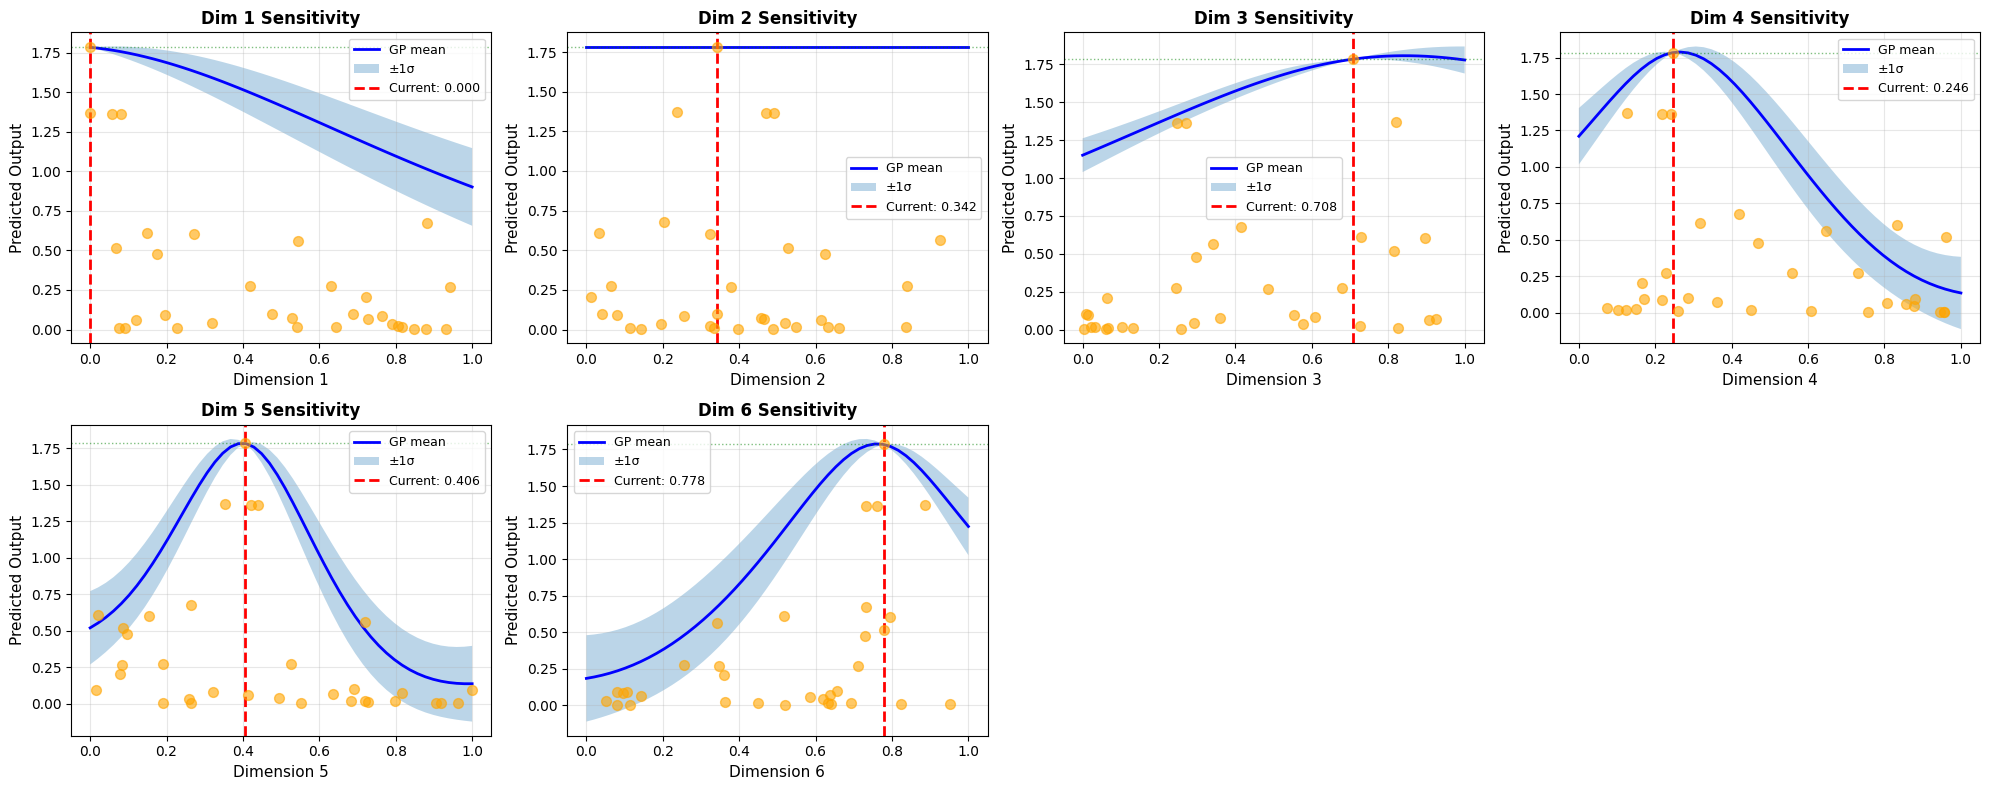



Function 8 (8D) - Sensitivity Analysis
Baseline (best point): [0.144443 0.040302 0.1      0.127071 1.       0.021611 0.1      0.984114]
Baseline output: 9.697180

Dimension 1: Max gradient = 0.0568 (flat - less important)
Dimension 2: Max gradient = 0.0198 (flat - less important)
Dimension 3: Max gradient = 0.0757 (flat - less important)
Dimension 4: Max gradient = 0.0276 (flat - less important)
Dimension 5: Max gradient = 0.0064 (flat - less important)
Dimension 6: Max gradient = 0.0000 (flat - less important)
Dimension 7: Max gradient = 0.0406 (flat - less important)
Dimension 8: Max gradient = 0.0000 (flat - less important)


/Users/mariana.lozynska/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


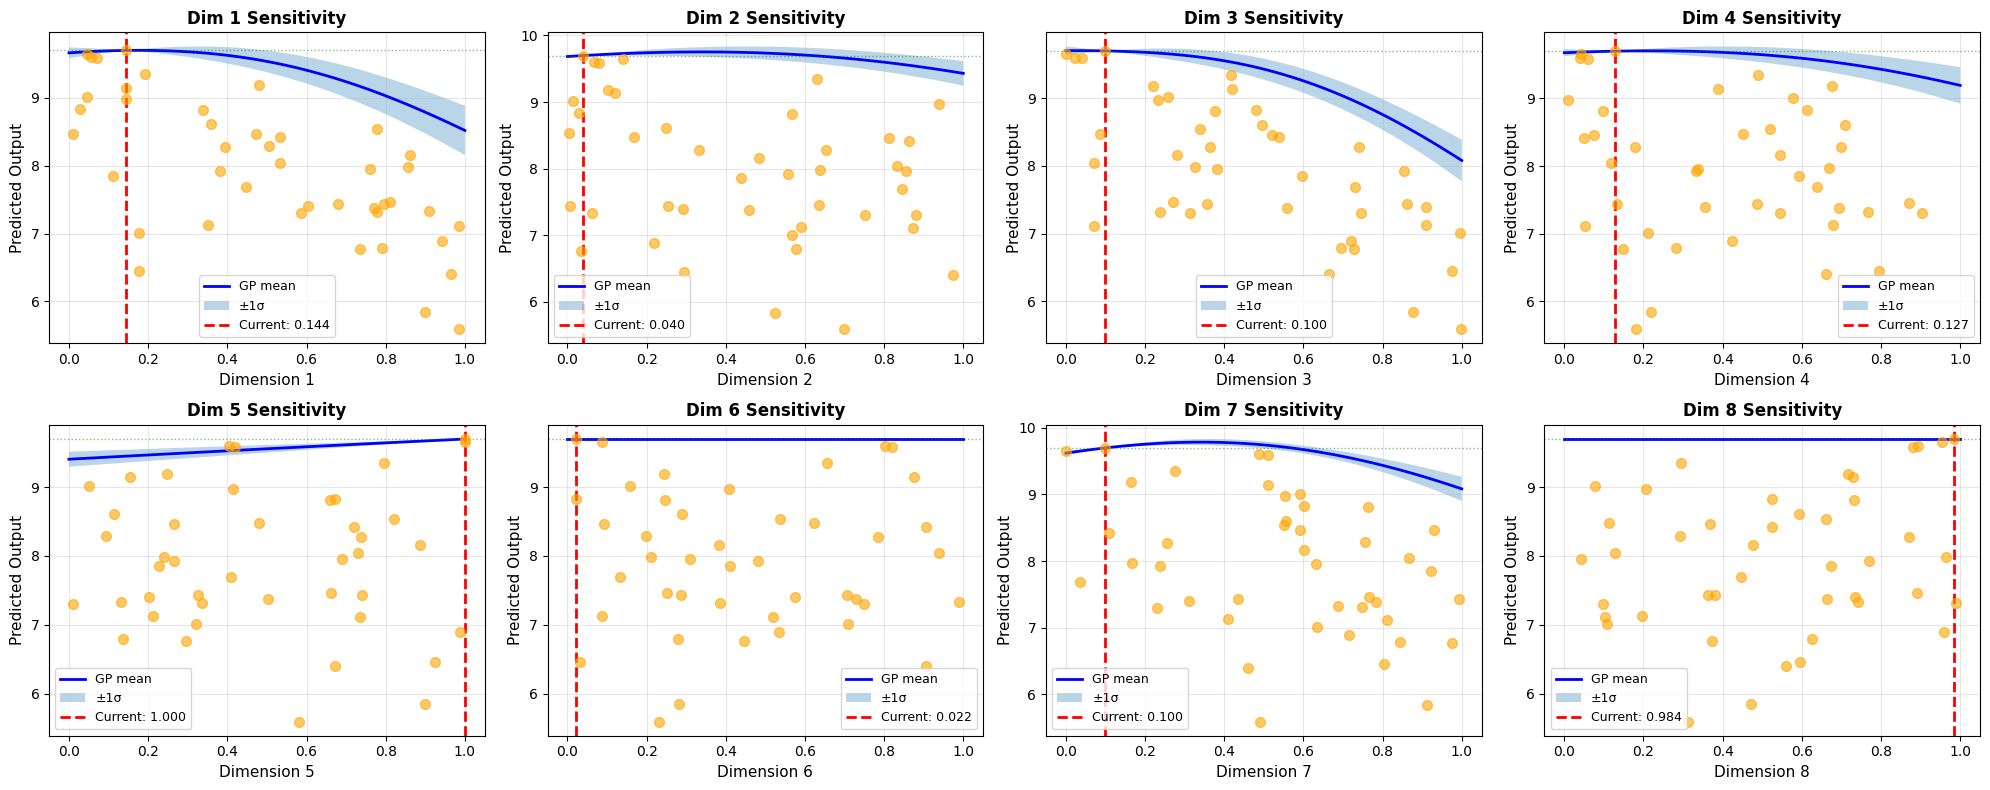

In [6]:
from utils.sensitivity import sensitivity_analysis

for func_id in range(1, 9):
    sensitivity_analysis(func_id, inputs[func_id], outputs[func_id])

## 5. Week 4 Strategy Design

Strategies based on 3-week performance trends, sensitivity analysis, and GP reliability assessment.

### Key insight: match acquisition function to GP reliability

- **EI/UCB** (deterministic) work well when the GP is reliable — they exploit the surrogate surface efficiently. Best for functions with consistent improvement history.
- **Thompson Sampling** (stochastic) works well when the GP is unreliable — it doesn't trust the mean surface, instead drawing random functions from the posterior. Best for functions where the GP has failed to guide improvements.

### Strategy rationale per function:

| F | Strategy | Bounds | Rationale |
|---|----------|--------|-----------|
| F1 | **EI** (xi=0.01) | ±0.03 from best | GP is reliable around the spike at [0.41, 0.40]. W3 found best=0.325. Tight EI exploits the narrow peak. |
| F2 | **EI** (xi=0.01) | dim1 ±0.05, dim2 free | Dim2 is flat (gradient≈0). Only dim1 matters. Narrow dim1 search, let dim2 vary freely. |
| F3 | **TS** (alpha=0.1) | ±0.15 from best | 0/3 weeks improved. GP overfits with default alpha. Regularised GP + TS gives maximum diversity. |
| F4 | **EI** (xi=0.005) | ±0.05 from best | Climbing steadily (0.352→0.423). Tighter bounds for fine-tuning. |
| F5 | **EI** (xi=0.001) | push to [1,1,1,1] | 7599 at [0.94,1,1,1]. Clear gradient toward corner. Lock dims 3&4, push dims 1&2. |
| F6 | **TS** | ±0.10 from best | W3 regressed (-0.521→-1.056). GP unreliable. TS explores where EI won't go, tight bounds prevent waste. |
| F7 | **UCB** (kappa=0.3) | ±0.08 from best | W3 overshot but W2 best is solid. Conservative fine-tuning. |
| F8 | **UCB** (kappa=0.3) | ±0.08 from best | Marginal gains (9.649→9.697). Conservative fine-tuning continues working. |

In [7]:
import warnings
import importlib
import utils.bayesian_optimization
importlib.reload(utils.bayesian_optimization)
from utils.bayesian_optimization import fit_gp, propose_next_point

week4_recommendations = {}

def get_best_point(fid):
    """Get the best observed point for a function"""
    best_idx = np.argmax(outputs[fid])
    return inputs[fid][best_idx].copy()

# Week 4 strategies — matched to GP reliability per function
# EI for reliable GP (F1, F2, F4, F5) — exploit accurate surrogate
# TS for unreliable GP (F3, F6) — don't trust the mean surface
# UCB for fine-tuning (F7, F8) — conservative exploitation
strategies = {
    1: {
        'acq': 'EI', 'xi': 0.01, 'kappa': 1.0,
        'anchor': 'best', 'radius': 0.03, 'alpha': 1e-6,
        'n_candidates': 2000,
        'note': 'EI tight ±0.03 — exploit reliable GP around spike'
    },
    2: {
        'acq': 'EI', 'xi': 0.01, 'kappa': 1.0,
        'anchor': 'custom', 'radius': None, 'alpha': 1e-6,
        'n_candidates': 2000,
        'note': 'EI — dim1 ±0.05, dim2 free (dim2 is flat)'
    },
    3: {
        'acq': 'TS', 'xi': 0.01, 'kappa': 1.0,
        'anchor': 'best', 'radius': 0.15,
        'alpha': 0.1,  # regularised GP — stop overfitting noise
        'n_candidates': 2000,
        'note': 'TS + regularised GP (alpha=0.1) — max diversity, ±0.15'
    },
    4: {
        'acq': 'EI', 'xi': 0.005, 'kappa': 1.0,
        'anchor': 'best', 'radius': 0.05, 'alpha': 1e-6,
        'n_candidates': 2000,
        'note': 'EI fine-tune ±0.05 near breakthrough'
    },
    5: {
        'acq': 'EI', 'xi': 0.001, 'kappa': 1.0,
        'anchor': 'custom', 'radius': None, 'alpha': 1e-6,
        'n_candidates': 2000,
        'note': 'EI — push all dims toward 1.0'
    },
    6: {
        'acq': 'TS', 'xi': 0.01, 'kappa': 1.0,
        'anchor': 'best', 'radius': 0.10, 'alpha': 1e-6,
        'n_candidates': 2000,
        'note': 'TS ±0.10 — GP unreliable after W3 regression'
    },
    7: {
        'acq': 'UCB', 'xi': 0.01, 'kappa': 0.3,
        'anchor': 'best', 'radius': 0.08, 'alpha': 1e-6,
        'n_candidates': 2000,
        'note': 'UCB conservative fine-tune ±0.08'
    },
    8: {
        'acq': 'UCB', 'xi': 0.01, 'kappa': 0.3,
        'anchor': 'best', 'radius': 0.08, 'alpha': 1e-6,
        'n_candidates': 2000,
        'note': 'UCB conservative fine-tune ±0.08'
    },
}

print("Week 4 Recommendations")
print("=" * 80)
print(f"{'F':>2} {'Dim':>3} {'Best':>12} {'Predicted':>12} {'Acq':>4} {'Note'}")
print("-" * 80)

for fid in range(1, 9):
    X, y = inputs[fid], outputs[fid]
    dim = X.shape[1]
    s = strategies[fid]
    
    # Build bounds
    bounds = np.array([[0.0, 1.0]] * dim)
    
    # Radial bounds from best point
    if s['anchor'] == 'best' and s['radius'] is not None:
        best_point = get_best_point(fid)
        r = s['radius']
        for d in range(dim):
            bounds[d] = [max(0, best_point[d] - r), min(1, best_point[d] + r)]
    
    # F2: dim1 ±0.05 from best, dim2 free [0,1]
    if fid == 2:
        best_point = get_best_point(fid)
        bounds[0] = [max(0, best_point[0] - 0.05), min(1, best_point[0] + 0.05)]
        bounds[1] = [0.0, 1.0]
    
    # F5: push toward [1,1,1,1]
    if fid == 5:
        bounds[0] = [0.94, 1.0]   # dim1: push from 0.94 to 1.0
        bounds[1] = [0.95, 1.0]   # dim2: push from ~1.0
        bounds[2] = [1.0, 1.0]    # dim3: locked at 1.0
        bounds[3] = [1.0, 1.0]    # dim4: locked at 1.0
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        next_point, gp = propose_next_point(
            X, y, bounds,
            acq_func=s['acq'], xi=s['xi'], kappa=s['kappa'],
            n_restarts=50, alpha=s['alpha'], n_candidates=s['n_candidates']
        )
    
    week4_recommendations[fid] = next_point
    best = np.max(y)
    pred = gp.predict(next_point.reshape(1, -1))[0]
    pred_std = gp.predict(next_point.reshape(1, -1), return_std=True)[1][0]
    
    # Distance from nearest existing point
    dists = np.linalg.norm(X - next_point, axis=1)
    min_dist = np.min(dists)
    
    print(f"{fid:>2} {dim:>3}D {best:>12.4f} {pred:>12.4f}   {s['acq']:>3}  {s['note']}")
    print(f"   {'':>3}  {'':>12} {'±':>6}{pred_std:<6.4f}  dist_nearest={min_dist:.4f}  point: {next_point}")
    print()

print("=" * 80)

Week 4 Recommendations
 F Dim         Best    Predicted  Acq Note
--------------------------------------------------------------------------------
 1   2D       0.3255       0.2994    EI  EI tight ±0.03 — exploit reliable GP around spike
                          ±0.0358  dist_nearest=0.0081  point: [0.41623666 0.40482742]

 2   2D       0.6138       0.6036    EI  EI — dim1 ±0.05, dim2 free (dim2 is flat)
                          ±0.0270  dist_nearest=0.0369  point: [0.68481985 0.88901995]



 3   3D      -0.0348      -0.0513    TS  TS + regularised GP (alpha=0.1) — max diversity, ±0.15
                          ±0.0443  dist_nearest=0.1975  point: [0.53236299 0.73377596 0.49016324]



 4   4D       0.4226       0.3731    EI  EI fine-tune ±0.05 near breakthrough
                          ±0.1768  dist_nearest=0.0403  point: [0.41650016 0.36636585 0.40526789 0.41114058]

 5   4D    7599.5025    8050.6418    EI  EI — push all dims toward 1.0
                          ±129.5622  dist_nearest=0.0621  point: [1. 1. 1. 1.]



 6   5D      -0.5210      -1.3946    TS  TS ±0.10 — GP unreliable after W3 regression
                          ±0.5003  dist_nearest=0.1095  point: [0.73581272 0.24570018 0.62444805 0.70045421 0.26186099]



 7   6D       1.7845       1.8113   UCB  UCB conservative fine-tune ±0.08
                          ±0.0423  dist_nearest=0.1175  point: [0.         0.2629189  0.787844   0.26961069 0.39511233 0.75643166]

 8   8D       9.6972       9.7734   UCB  UCB conservative fine-tune ±0.08
                          ±0.0731  dist_nearest=0.1817  point: [0.10746373 0.120302   0.02       0.207071   1.         0.0993584
 0.18       0.98663108]



## 6. Submission Format

In [8]:
# Submission format
print("=" * 70)
print("WEEK 4 SUBMISSION")
print("=" * 70)

for fid in range(1, 9):
    pt = week4_recommendations[fid]
    formatted = '-'.join(f'{x:.6f}' for x in pt)
    print(f"Function {fid}:\t{formatted}")

print("\n" + "=" * 70)
print("COPY-PASTE FORMAT (hyphen-separated)")
print("=" * 70)
for fid in range(1, 9):
    pt = week4_recommendations[fid]
    print(f"Function {fid}:\t[{', '.join(f'{x:.6f}' for x in pt)}]")

WEEK 4 SUBMISSION
Function 1:	0.416237-0.404827
Function 2:	0.684820-0.889020
Function 3:	0.532363-0.733776-0.490163
Function 4:	0.416500-0.366366-0.405268-0.411141
Function 5:	1.000000-1.000000-1.000000-1.000000
Function 6:	0.735813-0.245700-0.624448-0.700454-0.261861
Function 7:	0.000000-0.262919-0.787844-0.269611-0.395112-0.756432
Function 8:	0.107464-0.120302-0.020000-0.207071-1.000000-0.099358-0.180000-0.986631

COPY-PASTE FORMAT (hyphen-separated)
Function 1:	[0.416237, 0.404827]
Function 2:	[0.684820, 0.889020]
Function 3:	[0.532363, 0.733776, 0.490163]
Function 4:	[0.416500, 0.366366, 0.405268, 0.411141]
Function 5:	[1.000000, 1.000000, 1.000000, 1.000000]
Function 6:	[0.735813, 0.245700, 0.624448, 0.700454, 0.261861]
Function 7:	[0.000000, 0.262919, 0.787844, 0.269611, 0.395112, 0.756432]
Function 8:	[0.107464, 0.120302, 0.020000, 0.207071, 1.000000, 0.099358, 0.180000, 0.986631]
